In [2]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.filterwarnings("ignore")
import json

from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re

import requests

In [3]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

В этом блокноте будут лежать эксперименты с моделями и данными. Для начала, посмотрим, сможем ли улучшить качество, сгенерировав больше фичей.

In [4]:
data_rare = pd.read_csv('data_rare.csv', index_col=[0])

In [5]:
data_rare.loc[~data_rare['handshake'].isna(), 'is_handshake'] = 1
data_rare.loc[data_rare['is_handshake'].isna(), 'is_handshake'] = 0

In [6]:
fingerprint = []
alert_message = []
certificate = []
is_selfsigned = []

for i in range(0, len(data_rare)):
    fingerprint.append(len(re.findall('fingerprint', data_rare['handshake'].fillna('0')[i], flags=0)))
    alert_message.append(len(re.findall('alert_message', data_rare['packets'].fillna('0')[i], flags=0)))
    certificate.append(len(re.findall('certificate', data_rare['handshake'].fillna('0')[i], flags=0)))
    is_selfsigned.append(len(re.findall("'is_selfsigned': True", data_rare['handshake'].fillna('0')[i], flags=0)))

data_rare['fingerprint'] = fingerprint
data_rare['alert_message'] = alert_message
data_rare['certificate'] = certificate
data_rare['is_selfsigned'] = is_selfsigned

In [7]:
df = data_rare.drop(['index', 'packets', 'handshake', 'timestamps'], axis = 1)
df['country'] = pd.read_csv('data.csv')['country']

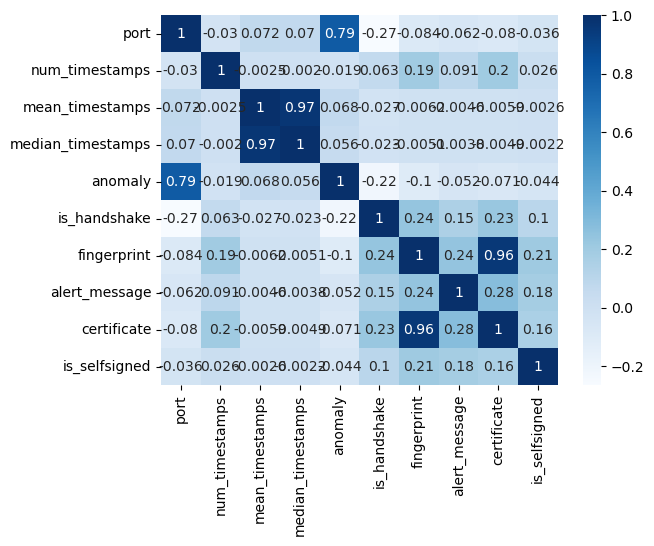

In [8]:
sns.heatmap(df[['addr', 'port', 'proto',
               'num_timestamps', 'mean_timestamps', 'median_timestamps', 'anomaly',
               'is_handshake', 'fingerprint', 'alert_message', 'certificate', 'is_selfsigned']].drop_duplicates().corr(), 
            cmap="Blues", annot=True);

# Подготовим данные:

1. Удалим скоррелированные колонки
2. Сделаем resemple для трейна
3. Скалируем

In [9]:
df = df.drop(['mean_timestamps', 'certificate', 'fingerprint'], axis = 1).drop_duplicates()

In [10]:
X = df[['addr', 'proto', 'num_timestamps', 
    'median_timestamps', 'anomaly', 'country', 'is_handshake',
       'alert_message', 'is_selfsigned']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']

In [11]:
X.anomaly.nunique()

2

In [12]:
X.shape

(17459, 9)

In [13]:
X['addr_1'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_1']

X['addr_2'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_2']

In [14]:
X.anomaly.nunique()

2

In [15]:
X.shape

(17459, 11)

In [16]:
X_new = X.drop(['proto', 'country', 'addr_1', 'addr_2'], 
                     axis=1).merge(pd.get_dummies(X[['proto', 'country', 'addr_1', 'addr_2']], drop_first = True),
                                                    left_index = True, right_index=True)

In [17]:
X_new.anomaly.nunique()

2

In [18]:
y = X_new['anomaly']
X = X_new.drop(['anomaly', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [19]:
!pip install imblearn

from imblearn.over_sampling import SMOTE
sm = SMOTE(#sampling_strategy = 0.9,
            random_state=0,
            k_neighbors=4)

X_train_res, y_train_res = sm.fit_resample(Xtrain, ytrain) 

In [123]:
y_train_res.value_counts()

0    11905
1    11905
Name: anomaly, dtype: int64

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_res)

In [21]:
X_train_res = scaler.transform(X_train_res)

In [22]:
Xtest = scaler.transform(Xtest)

In [23]:
from sklearn.metrics import make_scorer, fbeta_score

score = make_scorer(fbeta_score, beta=1.5)

In [40]:
# для проверки
def fbeta(beta, y, preds):
    d = pd.DataFrame(y, columns = ['y'])
    d['pr'] = preds
    TP = len(d[(d['y'] == 1) & (d['pr'] == 1)])
    TP_FP = len(d[(d['y'] == 1) & (d['pr'] == 1)]) + len(d[(d['y'] == 0) & (d['pr'] == 1)])
    TP_FN = len(d[(d['y'] == 1) & (d['pr'] == 1)]) + len(d[(d['y'] == 0) & (d['pr'] == 1)])
    precision = TP / TP_FP
    recall = TP / TP_FN
    return ((1 + beta*beta) * precision * recall) / (beta*beta*precision + recall)

В первую очередь возьмем катбуст из ноутбука с EDA и переберем параметры для улучшения качества.

# Итерация 1

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

params = {'depth': [None, 1, 5, 10],
          'learning_rate' : [None, 0.05, 0.1, 0.5],
          'iterations'    : [None, 100, 200]
         }

ctb = CatBoostClassifier(random_state=42, verbose=False)

ctb_model = GridSearchCV(ctb, params, scoring=score, return_train_score=True, verbose=2.1)
ctb_model.fit(X_train_res, y_train_res)
print(ctb_model.best_params_)
print(ctb_model.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.994, test=0.991) total time=  11.7s
[CV 2/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.993, test=0.993) total time=  11.7s
[CV 3/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.994, test=0.992) total time=  11.9s
[CV 4/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.994, test=0.991) total time=  12.0s
[CV 5/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.993, test=0.993) total time=  11.8s
[CV 1/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.994, test=0.992) total time=  11.9s
[CV 2/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.994, test=0.994) total time=  11.9s
[CV 3/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.994, test=0.993) total time=  11.8s
[CV 4/5] END depth=None, i

[CV 4/5] END depth=1, iterations=None, learning_rate=0.1;, score=(train=0.989, test=0.987) total time=   8.9s
[CV 5/5] END depth=1, iterations=None, learning_rate=0.1;, score=(train=0.989, test=0.987) total time=   8.9s
[CV 1/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.995, test=0.991) total time=   8.7s
[CV 2/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.994) total time=   8.6s
[CV 3/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.993) total time=   8.7s
[CV 4/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.992) total time=   8.8s
[CV 5/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.994) total time=   8.7s
[CV 1/5] END depth=1, iterations=100, learning_rate=None;, score=(train=0.978, test=0.977) total time=   3.1s
[CV 2/5] END depth=1, iterations=100, learning_rate=None;, score=(train=0.977, test=0.975) total time=   3.2s
[CV 3/5] E

[CV 4/5] END depth=5, iterations=100, learning_rate=0.05;, score=(train=0.965, test=0.962) total time=   3.8s
[CV 5/5] END depth=5, iterations=100, learning_rate=0.05;, score=(train=0.966, test=0.968) total time=   4.2s
[CV 1/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.980, test=0.977) total time=   3.6s
[CV 2/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.981, test=0.979) total time=   3.6s
[CV 3/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.981, test=0.979) total time=   3.5s
[CV 4/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.981, test=0.978) total time=   3.7s
[CV 5/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.980, test=0.980) total time=   3.9s
[CV 1/5] END depth=5, iterations=100, learning_rate=0.5;, score=(train=0.994, test=0.992) total time=   3.8s
[CV 2/5] END depth=5, iterations=100, learning_rate=0.5;, score=(train=0.994, test=0.993) total time=   3.5s
[CV 3/5] END dept

[CV 4/5] END depth=10, iterations=200, learning_rate=None;, score=(train=0.995, test=0.992) total time=  11.0s
[CV 5/5] END depth=10, iterations=200, learning_rate=None;, score=(train=0.994, test=0.994) total time=  10.0s
[CV 1/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.986, test=0.982) total time=  10.1s
[CV 2/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.987, test=0.985) total time=  11.1s
[CV 3/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.987, test=0.985) total time=  10.5s
[CV 4/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.988, test=0.986) total time=  10.3s
[CV 5/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.987, test=0.987) total time=  10.2s
[CV 1/5] END depth=10, iterations=200, learning_rate=0.1;, score=(train=0.993, test=0.989) total time=  10.3s
[CV 2/5] END depth=10, iterations=200, learning_rate=0.1;, score=(train=0.993, test=0.992) total time=  10.1s
[CV

KeyError: 'depth'

In [26]:
print(ctb_model.best_params_)
print(ctb_model.best_score_)

{'depth': None, 'iterations': None, 'learning_rate': 0.1}
0.9934767719061706


In [27]:
clf = CatBoostClassifier(random_state=42, verbose=False,
                        depth= None, iterations= None, learning_rate= 0.1)

In [28]:
model_ctb = clf.fit(X_train_res, y_train_res)

In [29]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_ctb.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_ctb.predict(Xtest)), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.98


In [30]:
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_ctb.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_ctb.predict(Xtest), beta=1.5), 2)}")

f1_score на трейне: 0.99
f1_score на тесте: 0.81


In [41]:
fbeta(1.5, list(y_train_res), list(model_ctb.predict(X_train_res)))

0.98298926507019

In [42]:
fbeta(1.5, list(ytest), list(model_ctb.predict(Xtest)))

0.5785123966942147

In [43]:
# сильно переобучилась под трейн

model AUC score: 0.9829498971853097


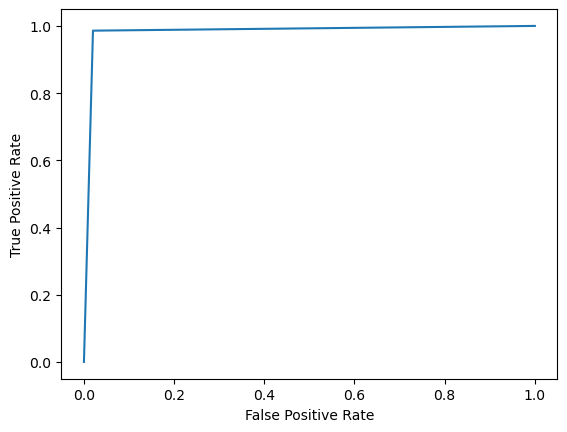

In [44]:
plot_roc_curve(ytest, model_ctb.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model_ctb.predict(Xtest))}')

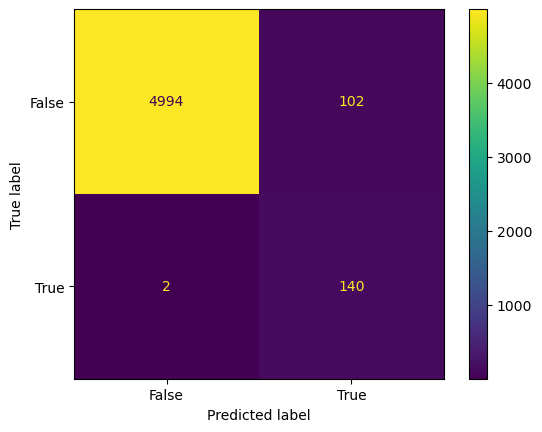

In [45]:
confusion_matrix = confusion_matrix(ytest, model_ctb.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()
# много ошибается на определении аноималии

In [46]:
feat = pd.DataFrame(model_ctb.feature_importances_,
            columns=['coefs'])
feat['features'] = list(X_new.drop(['addr', 'anomaly'], axis=1).columns)

In [47]:
feat = feat.sort_values('coefs', ascending=False).head(20)

<function matplotlib.pyplot.show(close=None, block=None)>

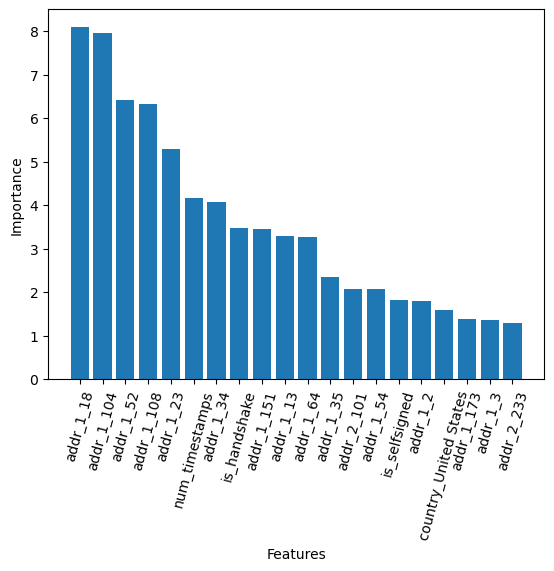

In [48]:
plt.bar(feat['features'], feat['coefs'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=75)
plt.show

In [21]:
import pickle
pickle.dump(model, open('ctb_model.pkl', 'wb'))

In [22]:
import joblib

joblib.dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

# Итерация 2

max_depth поставить меньше

In [75]:
from sklearn.ensemble import RandomForestClassifier

params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 4, 5],
    'criterion' :['gini', 'entropy']
    }
rfc = RandomForestClassifier(random_state=42)

rfc_model = GridSearchCV(rfc, params, scoring=score)
rfc_model.fit(X_train_res, y_train_res)
print(rfc_model.best_params_)
print(rfc_model.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500}
0.9510595628978035


In [78]:
clf = RandomForestClassifier(random_state=42, criterion = 'entropy',
                            max_depth= 5, max_features = 'log2', n_estimators = 500)

In [79]:
model_rfc = clf.fit(X_train_res, y_train_res)

In [80]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_rfc.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_rfc.predict(Xtest)), 2)}")

roc_auc_score на трейне: 0.92
roc_auc_score на тесте: 0.91


In [81]:
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_rfc.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_rfc.predict(Xtest), beta=1.5), 2)}")

f1_score на трейне: 0.95
f1_score на тесте: 0.35


In [82]:
fbeta(1.5, list(y_train_res), list(model_rfc.predict(X_train_res)))

0.8664864074831921

In [83]:
fbeta(1.5, list(ytest), list(model_rfc.predict(Xtest)))

0.14402451481103168

In [84]:
# сильно переобучилась

# Итерация 3

In [60]:
from sklearn.linear_model import LogisticRegression

params = {"penalty":["none","l2","l1"]}

lr = LogisticRegression(random_state=42)

lr_model = GridSearchCV(lr, params, scoring=score)
lr_model.fit(X_train_res, y_train_res)
print(lr_model.best_params_)
print(lr_model.best_score_)

{'penalty': 'l2'}
0.9935479234764705


In [61]:
clf = LogisticRegression(random_state=42, penalty= 'l2')
model_lr = clf.fit(X_train_res, y_train_res)

In [62]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_lr.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_lr.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_lr.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_lr.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.98
f1_score на трейне: 0.99
f1_score на тесте: 0.82


In [63]:
# здесь куда лучше результат

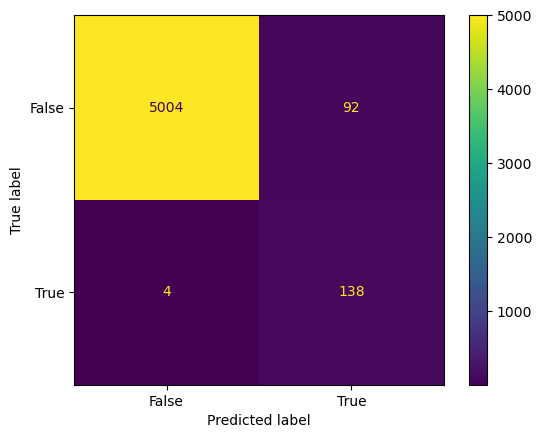

In [64]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


confusion_matrix = confusion_matrix(ytest, model_lr.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

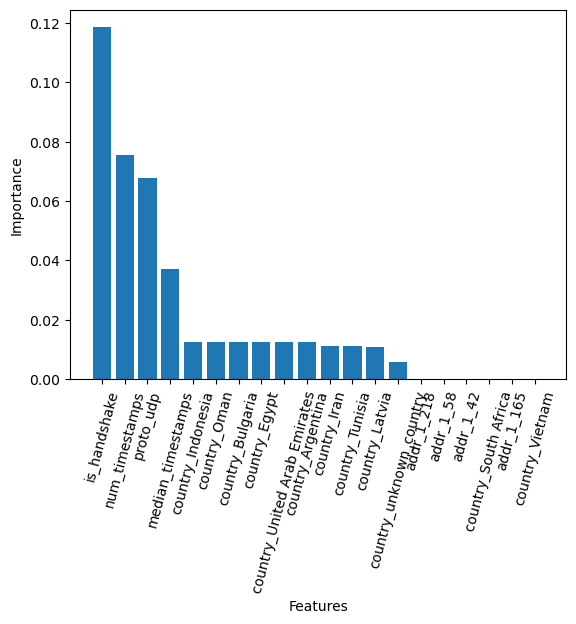

In [65]:
feat = pd.DataFrame(model_lr.coef_[0],
            columns=['coefs'])
feat['features'] = list(X_new.drop(['addr', 'anomaly'], axis=1).columns)
feat = feat.sort_values('coefs', ascending=False).head(20)

plt.bar(feat['features'], feat['coefs'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=75)
plt.show

In [66]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = model_lr.predict(Xtest)

In [67]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# 3 процента выбросов не задетектировали

0.028169014084507043

In [68]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.01805337519623234

In [69]:
len(C[(C['real']==1)])

142

# Итерация 4: несколько моделей из pyod

In [70]:
from pyod.models.inne import INNE

params = {'n_estimators': [50,100,200,500]}

inn = INNE(random_state=42)

inn_model = GridSearchCV(inn, params, scoring=score)
inn_model.fit(X_train_res, y_train_res)
print(inn_model.best_params_)
print(inn_model.best_score_)

{'n_estimators': 500}
0.004600386068620404


In [71]:
clf = INNE(random_state=42, n_estimators = 500)
model_inn = clf.fit(X_train_res, y_train_res)

In [72]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_inn.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_inn.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_inn.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_inn.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.4
roc_auc_score на тесте: 0.42
f1_score на трейне: 0.0
f1_score на тесте: 0.01


In [73]:
# здесь совсем слабо
# Возможно, нормальная модель, но надо наоборот развернуть значения

In [74]:
pr = list(model_inn.predict(X_train_res))
pr[pr.index(1)] = 3
pr[pr.index(0)] = 1
pr[pr.index(3)] = 0

fbeta_score(y_train_res, pr, beta=1.5)
# кажется, развернуть значения не сработало

0.0011145691332938947

In [85]:
from pyod.models.cblof import CBLOF

params = {'n_clusters': [5,10,50,100]
         }

cblof = CBLOF(random_state=42)

cblof_model = GridSearchCV(cblof, params, scoring=score)
cblof_model.fit(X_train_res, y_train_res)
print(cblof_model.best_params_)
print(cblof_model.best_score_)

{'n_clusters': 50}
0.004574811237290013


In [86]:
clf = CBLOF(random_state=42, n_clusters = 50)
model_cblof = clf.fit(X_train_res, y_train_res)

In [87]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_cblof.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_cblof.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_cblof.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_cblof.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.4
roc_auc_score на тесте: 0.42
f1_score на трейне: 0.0
f1_score на тесте: 0.02


In [88]:
pr = list(model_cblof.predict(X_train_res))

In [89]:
pr[pr.index(1)] = 3
pr[pr.index(0)] = 1
pr[pr.index(3)] = 0

In [90]:
fbeta_score(y_train_res, pr, beta=1.5)
# кажется, развернуть значения не сработало

0.0014485424577222743

In [91]:
from pyod.models.dif import DIF

params = {'batch_size': [8,256,1000]
         }
dif = DIF(random_state=42)

dif_model = GridSearchCV(dif, params, scoring=score)
dif_model.fit(X_train_res, y_train_res)
print(dif_model.best_params_)
print(dif_model.best_score_)

{'batch_size': 8}
0.03954684619438563


In [92]:
clf = DIF(random_state=42, batch_size = 8)
model_dif = clf.fit(X_train_res, y_train_res)

In [93]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_dif.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_dif.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_dif.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_dif.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.5
roc_auc_score на тесте: 0.5
f1_score на трейне: 0.0
f1_score на тесте: 0.0


In [94]:
from pyod.models.ocsvm import OCSVM

params = {'kernel': ['poly', 'rbf', 'sigmoid']
         }
ocsvm = OCSVM()

ocsvm_model = GridSearchCV(ocsvm, params, scoring=score)
ocsvm_model.fit(X_train_res, y_train_res)
print(ocsvm_model.best_params_)
print(ocsvm_model.best_score_)

{'kernel': 'poly'}
0.25710952513964264


In [95]:
clf = OCSVM(kernel= 'poly')
model_ocsvm = clf.fit(X_train_res, y_train_res)

In [96]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_ocsvm.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_ocsvm.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_ocsvm.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_ocsvm.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.6
roc_auc_score на тесте: 0.58
f1_score на трейне: 0.26
f1_score на тесте: 0.21


In [97]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'max_depth': [3, 10, 50],
          'learning_rate' : [0.01,0.1,0.5],
          'n_estimators': [20, 100, 200]
         }
gbc = GradientBoostingClassifier(random_state=42)

gbc_model = GridSearchCV(gbc, params, scoring=score, verbose=2.1)
gbc_model.fit(X_train_res, y_train_res)
print(gbc_model.best_params_)
print(gbc_model.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.839 total time=   5.8s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.843 total time=   5.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.841 total time=   6.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.837 total time=   5.9s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.842 total time=   5.9s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.859 total time=  30.4s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.843 total time=  33.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.854 total time=  30.9s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.851 total time=  31.7s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.852 to

[CV 1/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.968 total time=12.6min
[CV 2/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.988 total time=13.1min
[CV 3/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.982 total time=12.3min
[CV 4/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.985 total time=15.4min
[CV 5/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.986 total time=15.9min
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.951 total time=   9.2s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.951 total time=   8.9s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.955 total time=   9.2s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.951 total time=   8.5s
[CV 5/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.951 total time=   9.0s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_est

In [108]:
clf = GradientBoostingClassifier(random_state=42, max_depth = 10, 
                                learning_rate = 0.5, n_estimators = 100)
model_gbc = clf.fit(X_train_res, y_train_res)

In [109]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, model_gbc.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_gbc.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, model_gbc.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_gbc.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.98
f1_score на трейне: 0.99
f1_score на тесте: 0.79


In [110]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = model_gbc.predict(Xtest)

In [111]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# меньше одного процента выбросов

0.007042253521126761

In [112]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.023547880690737835

Итого, лучше всего себя проявила логистическая регрессия, градиентный бустинг и катбуст. Попробуем чуть улучшить логистическую регессию и построить над ней бэггинг.

In [113]:
from sklearn.ensemble import BaggingClassifier

lr = LogisticRegression(random_state=42, penalty= 'l2')
bc = BaggingClassifier(lr)
bag = bc.fit(X_train_res, y_train_res)
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_train_res, bag.predict(X_train_res)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, bag.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_train_res, bag.predict(X_train_res), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, bag.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.97
f1_score на трейне: 0.99
f1_score на тесте: 0.81


In [114]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = bag.predict(Xtest)

In [115]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# меньше 1 процента процента выбросов не задетектировали

0.035211267605633804

In [116]:
len(C[(C['real']==1) & (C['preds']==0)])

5

In [117]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.018642072213500786

Посмотрим на процент ошибочных решений моделей

In [118]:
models_list = [model_ctb, model_rfc, model_lr, model_inn, model_cblof, model_dif, model_ocsvm, model_gbc, bag]

In [119]:
perc_anomaly = []
perc_usual = []

for i in models_list:
    C = pd.DataFrame(list(ytest), columns=['real'])
    C['preds'] = i.predict(Xtest)
    perc_anomaly.append(len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)]))
    perc_usual.append(len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)]))

In [120]:
models_names = ['model_ctb', 'model_rfc', 'model_lr', 'model_inn', 'model_cblof', 'model_dif', 'model_ocsvm', 'model_gbc', 'bag']
mistakes_df = pd.DataFrame(index = models_names, columns = ['perc_anomaly', 'perc_usual'])
mistakes_df['perc_anomaly'] = perc_anomaly
mistakes_df['perc_usual'] = perc_usual
mistakes_df

,perc_anomaly,perc_usual
model_ctb,0.014085,0.020016
model_rfc,0.007042,0.164443
model_lr,0.028169,0.018053
model_inn,0.957746,0.203493
model_cblof,0.950704,0.205848
model_dif,1.000000,0.000000
model_ocsvm,0.838028,0.004317
model_gbc,0.007042,0.023548
bag,0.035211,0.018642
